In [30]:
import numpy as np
import pandas as pd
from river.datasets import synth
from river import linear_model
from river import metrics
from river import optim
from river import preprocessing
from river import drift
from river import datasets
import pickle
import matplotlib.pyplot as plt

In [31]:
# Function to return samples with a rolling average mean window
def moving_average(datastream, window_size):

    datastream_series = pd.Series(datastream)
    windows = datastream_series.rolling(window_size)
    moving_averages = windows.mean()

    return moving_averages.tolist()[window_size - 1:]

#### Sliding window 

In [32]:
# Create mini-batch of features and labels
from sklearn.metrics import accuracy_score

labels = list()
features = list()
predictions = list()
def create_mini_batch(feature, label, prediction, batch_size=5):

    labels.append(label)
    features.append(feature)
    predictions.append(int(prediction))
    
    label_window = pd.Series(labels)[-batch_size:]
    feature_window = pd.DataFrame(features)[-batch_size:]
    pred_window = pd.Series(predictions)[-batch_size:]
    
    accuracy = accuracy_score(label_window, pred_window)
    
    return feature_window, label_window, accuracy

In [33]:
# Load dataset
dataset = synth.Agrawal(
     classification_function=0,
     seed=42
)

# Load pickled model
LogRegmodel1 = pickle.load(open('/home/jaydeep/book_ML_drifts/chapter_5/saved_models/river_model.pkl', 'rb'))

# Initialise metric
metric = metrics.Accuracy()

# buffers to store data stream for re-trainig model
# feature_buffer = list()
# label_buffer = list()
accuracy_buffer_1 = list()

# batch size
batch_size = 10
window_size = 2

for i,data in enumerate(dataset.take(1000),1):
    # data[0] - features, data[1] - label
    y_pred = LogRegmodel1.predict_one(data[0])
    metric = metric.update(data[1],y_pred)
    feature_buffer,label_buffer, accuracy = create_mini_batch(data[0],data[1],y_pred,window_size*batch_size)
    if i%batch_size==0:
        accuracy_buffer_1.append(accuracy)
        print(feature_buffer.iloc[:,:2])
        print(f'Training model with sliding window')
        LogRegmodel1.learn_many(feature_buffer,label_buffer)
        print(LogRegmodel1)

print(metric)

          salary    commission
0   68690.215450  81303.572981
1   98144.951527      0.000000
2  148987.502708      0.000000
3   26066.536218  83031.663913
4   98980.830747      0.000000
5   70104.145330  11197.468917
6  138211.652270      0.000000
7   93801.042617      0.000000
8  139843.650553      0.000000
9   96277.651536      0.000000
Training model with sliding window
StandardScaler | LogisticRegression
           salary    commission
0    68690.215450  81303.572981
1    98144.951527      0.000000
2   148987.502708      0.000000
3    26066.536218  83031.663913
4    98980.830747      0.000000
5    70104.145330  11197.468917
6   138211.652270      0.000000
7    93801.042617      0.000000
8   139843.650553      0.000000
9    96277.651536      0.000000
10  148295.301758      0.000000
11  112474.453857      0.000000
12  101028.756488      0.000000
13   96868.712402      0.000000
14  118902.056320      0.000000
15   93225.824357      0.000000
16   40958.767343  79727.323926
17   35871.4

In [34]:
# Overall Accuracy
print(metric)

Accuracy: 53.10%


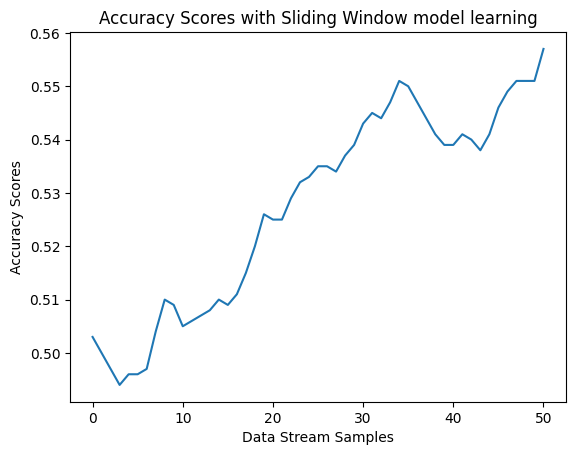

In [35]:
def plot():
    acc_scores_1_moving_avg = moving_average(accuracy_buffer_1,50)
    plt.plot(acc_scores_1_moving_avg)
    plt.xlabel('Data Stream Samples')
    plt.ylabel('Accuracy Scores')
    plt.title('Accuracy Scores with Sliding Window model learning')
    plt.show()
plot()

#### Landmark window

In [36]:
# Create mini-batch of features and labels
from sklearn.metrics import accuracy_score

labels = list()
features = list()
predictions = list()
def create_mini_batch1(feature, label, prediction, batch_size):

    labels.append(label)
    features.append(feature)
    predictions.append(int(prediction))
    
    label_window = pd.Series(labels)[-batch_size:]
    feature_window = pd.DataFrame(features)[-batch_size:]
    pred_window = pd.Series(predictions)[-batch_size:]
    
    accuracy = accuracy_score(label_window, pred_window)
    
    return feature_window, label_window, accuracy

In [37]:
# Load dataset
dataset = synth.Agrawal(
     classification_function=0,
     seed=42
)

# Load pickled model
LogRegmodel2 = pickle.load(open('/home/jaydeep/book_ML_drifts/chapter_5/saved_models/river_model.pkl', 'rb'))

# Initialise metric
metric = metrics.Accuracy()

# buffers to store data stream for re-trainig model
# feature_buffer = list()
# label_buffer = list()
accuracy_buffer_2 = list()

# batch size
batch_size = 5
window_size = 2

for i,data in enumerate(dataset.take(1000),1):
    # data[0] - features, data[1] - label
    y_pred = LogRegmodel2.predict_one(data[0])
    metric = metric.update(data[1],y_pred)
    if i%window_size!=0:
        feature_buffer,label_buffer, accuracy = create_mini_batch1(data[0],data[1],y_pred,batch_size)
        if i%batch_size==0:
            accuracy_buffer_2.append(accuracy)
            print(feature_buffer.iloc[:,:2])
            print(f'Training model with landmark window')
            LogRegmodel2.learn_many(feature_buffer,label_buffer)
            print(LogRegmodel2)


          salary    commission
0   68690.215450  81303.572981
1  148987.502708      0.000000
2   98980.830747      0.000000
Training model with landmark window
StandardScaler | LogisticRegression
          salary  commission
3  138211.652270         0.0
4  139843.650553         0.0
5  148295.301758         0.0
6  101028.756488         0.0
7  118902.056320         0.0
Training model with landmark window
StandardScaler | LogisticRegression
           salary    commission
8    40958.767343  79727.323926
9    74263.430409  26658.085785
10   59114.180276  31363.037078
11   68055.079288  28161.995371
12  112449.439217      0.000000
Training model with landmark window
StandardScaler | LogisticRegression
           salary    commission
13  105797.925984      0.000000
14  131322.157944      0.000000
15  109946.375700      0.000000
16   54476.307799  28299.223253
17  149291.566404      0.000000
Training model with landmark window
StandardScaler | LogisticRegression
           salary    commissio

In [38]:
# Overall Accuracy
print(metric)

Accuracy: 52.10%


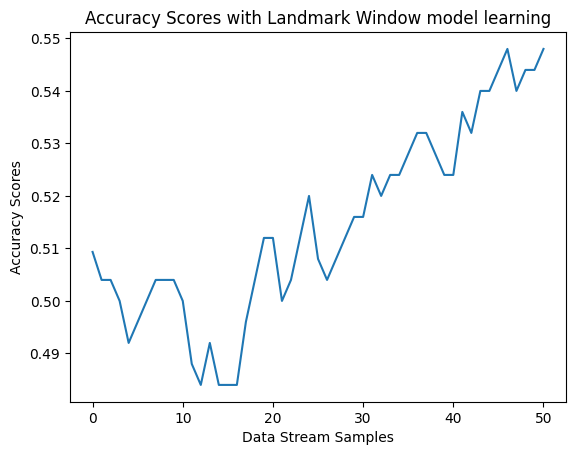

In [39]:
def plot():
    acc_scores_2_moving_avg = moving_average(accuracy_buffer_2,50)
    plt.plot(acc_scores_2_moving_avg)
    plt.xlabel('Data Stream Samples')
    plt.ylabel('Accuracy Scores')
    plt.title('Accuracy Scores with Landmark Window model learning')
    plt.show()
plot()